In [ ]:
import os
import torch
import torch.nn as nn
from PIL import Image
import torchvision.datasets as dsets
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch_directml
import shutil
import torchvision.transforms as transforms
from transformers import ViTImageProcessor
from scores import score_in_details
import pandas as pd
torch.manual_seed(240)

In [ ]:
dml = torch_directml.device()

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = (299, 299)),
        transforms.ToTensor(),
        ])

In [ ]:
class MyDataset(Dataset):
    def __init__(self,imgs,image_processor,label):
        self.imgs = imgs
        self.image_processor=image_processor
        self.label=label
                
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):            
        img = self.imgs[idx]
        image = Image.open(img).convert('RGB')
        pixel_values = self.image_processor(image, return_tensors="pt").pixel_values
        label = self.label[idx]
            
        return {"pixel_values": pixel_values.squeeze(),
                "labels": label,
                "path": img}

In [ ]:
dataset_path = "../splitted/test"
test_dataset = dsets.ImageFolder(root=dataset_path)
test_df = pd.DataFrame(test_dataset.imgs, columns = ['Image','Label'])

In [ ]:
image_processor = ViTImageProcessor.from_pretrained("microsoft/swin-base-patch4-window12-384")

In [ ]:
test_ds = MyDataset(imgs = test_df['Image'].tolist(),image_processor = image_processor, label = test_df['Label'].tolist())
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=10, drop_last=True, shuffle=False)

In [ ]:
def create_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs,  2)
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    return model.to(dml)
    
base_model = create_model()

In [ ]:
model_path = "../trained-models/braintumor_swin_inceptionV3.pt"
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)

In [ ]:
base_model = base_model.to(dml)

In [24]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    base_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['pixel_values'].to(dml)
            labels = batch['labels']
            path = batch["path"]
            
            outputs = softmax(base_model(inputs))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(probs.numpy())
                
            preds = preds.cpu()
            
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [25]:
pred, real, probas, misclassified = get_predictions()
print(classification_report(real, pred, digits=6))

  0%|          | 0/1886 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.945557  0.987612  0.966127      4924
           1   0.995553  0.979908  0.987669     13936

    accuracy                       0.981919     18860
   macro avg   0.970555  0.983760  0.976898     18860
weighted avg   0.982500  0.981919  0.982044     18860



Accuracy: 98.19194061505833%
Precision: 0.9824999523404065
Recall: 0.9819194061505833
F1-score: 0.9820444756916776
MCC-score: 0.95422357744159
ROC AUC score: 0.8978104020957824




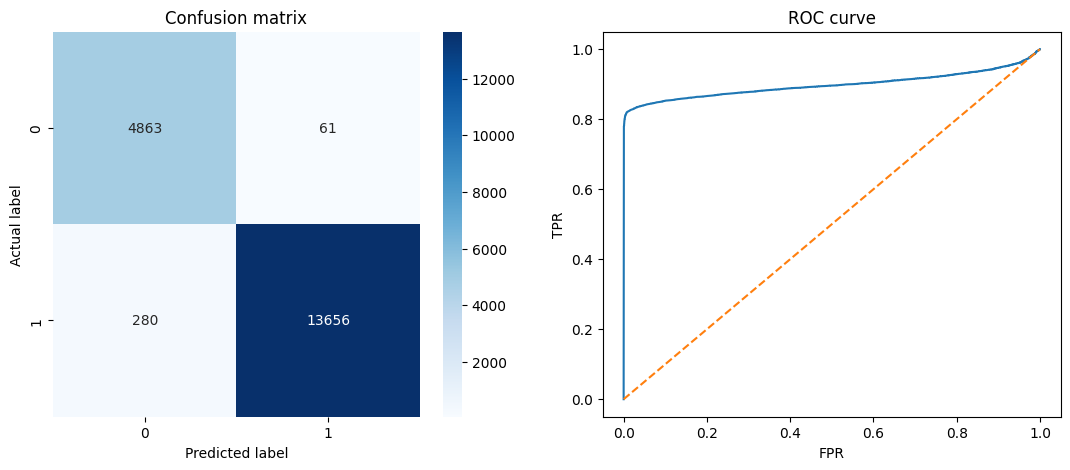

In [26]:
score_in_details(pred=pred, real=real, probas=probas)

In [27]:
dest = "../images/misclassified-new/swin-inception"
for path, actual, pred in tqdm(misclassified):
    img_name = path.split("\\")[-1].split(".")[0]
    ext = path.split(".")[-1]
    shutil.copy(path, os.path.join(dest, f"{img_name}_{actual}_{pred}.{ext}"))

  0%|          | 0/341 [00:00<?, ?it/s]